In [1]:
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

In [2]:
mnist_train = pd.read_csv('Data/digit-recognizer/train.csv').astype(np.float32)
mnist_test = pd.read_csv('Data/digit-recognizer/test.csv').astype(np.float32)

In [3]:
y_train = mnist_train[['label']][:30000]
x_train = mnist_train[['pixel' + str(idx) for idx in range(784)]][:30000]

y_dev = mnist_train[['label']][30000:42000]
x_dev = mnist_train[['pixel' + str(idx) for idx in range(784)]][30000:42000]

x_test = mnist_test[['pixel' + str(idx) for idx in range(784)]]


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_dev = scaler.transform(x_dev)
x_test = scaler.transform(x_test)

print(x_train.shape, y_train.shape, x_dev.shape, y_dev.shape, x_test.shape)

(30000, 784) (30000, 1) (12000, 784) (12000, 1) (28000, 784)


In [5]:
ys = y_train.astype(int).values.reshape(-1)
xs = x_train
ys_one_hot = tf.one_hot(ys, 10)

ys_test = y_dev.astype(int).values.reshape(-1)
xs_test = x_dev

In [6]:
#model
def _minimize(strategy, tape, optimizer, loss, trainable_variables):
    """Minimizes loss for one step by updating `trainable_variables`.
    This is roughly equivalent to
    ```python
    gradients = tape.gradient(loss, trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, trainable_variables))
    ```
    However, this function also applies gradient clipping and loss scaling if the
    optimizer is a LossScaleOptimizer.
    Args:
    strategy: `tf.distribute.Strategy`.
    tape: A gradient tape. The loss must have been computed under this tape.
    optimizer: The optimizer used to minimize the loss.
    loss: The loss tensor.
    trainable_variables: The variables that will be updated in order to minimize
    the loss.
    """

    with tape:
        if isinstance(optimizer, lso.LossScaleOptimizer):
            loss = optimizer.get_scaled_loss(loss)

    gradients = tape.gradient(loss, trainable_variables)

    # Whether to aggregate gradients outside of optimizer. This requires support
    # of the optimizer and doesn't work with ParameterServerStrategy and
    # CentralStroageStrategy.
    aggregate_grads_outside_optimizer = (
        optimizer._HAS_AGGREGATE_GRAD and  # pylint: disable=protected-access
        not isinstance(strategy.extended,
                       parameter_server_strategy.ParameterServerStrategyExtended))

    if aggregate_grads_outside_optimizer:
        # We aggregate gradients before unscaling them, in case a subclass of
        # LossScaleOptimizer all-reduces in fp16. All-reducing in fp16 can only be
        # done on scaled gradients, not unscaled gradients, for numeric stability.
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
                                                       trainable_variables))
    if isinstance(optimizer, lso.LossScaleOptimizer):
        gradients = optimizer.get_unscaled_gradients(gradients)
    gradients = optimizer._clip_gradients(gradients)  # pylint: disable=protected-access
    if trainable_variables:
        if aggregate_grads_outside_optimizer:
            optimizer.apply_gradients(
                zip(gradients, trainable_variables),
                experimental_aggregate_gradients=False)
        else:
            optimizer.apply_gradients(zip(gradients, trainable_variables))

class Model(tf.keras.Model):
    def __init__(self, cl_coeff, dropout_rate = 0.0, variance_epsilon=1e-3, stddev = 0.1, bias = 0.1):
        super(Model, self).__init__()
        #Initialize model variables as in LENETs++
        self.W_conv1 = tf.Variable(tf.random.truncated_normal([5, 5, 1, 32], stddev=stddev), name="W_conv1")
        self.b_conv1 = tf.Variable(tf.constant(bias, shape=[32]), name="b_conv1")   
        self.W_conv1_2 = tf.Variable(tf.random.truncated_normal([5, 5, 32, 32], stddev=stddev), name="W_conv1_2")
        self.b_conv1_2 = tf.Variable(tf.constant(bias, shape=[32]), name="b_conv1_2")   
        self.W_conv2 = tf.Variable(tf.random.truncated_normal([5, 5, 32, 64], stddev=stddev), name="W_conv2")
        self.b_conv2 = tf.Variable(tf.constant(bias, shape=[64]), name="b_conv2") 
        self.W_conv2_2 = tf.Variable(tf.random.truncated_normal([5, 5, 64, 64], stddev=stddev), name="W_conv2_2")
        self.b_conv2_2 = tf.Variable(tf.constant(bias, shape=[64]), name="b_conv2_2")
        self.W_conv3 = tf.Variable(tf.random.truncated_normal([5, 5, 64, 128], stddev=stddev), name="W_conv3")
        self.b_conv3 = tf.Variable(tf.constant(bias, shape=[128]), name="b_conv3")  
        self.W_conv3_2 = tf.Variable(tf.random.truncated_normal([5, 5, 128, 128], stddev=stddev), name="W_conv3_2")
        self.b_conv3_2 = tf.Variable(tf.constant(bias, shape=[128]), name="b_conv3_2")
        #FC layers, only 1 for LeNets
        self.W_fc1 = tf.Variable(tf.random.truncated_normal([4 * 4 * 128, 2], stddev=stddev), name="W_fc1")
        self.b_fc1 = tf.Variable(tf.constant(bias, shape=[2]), name="b_fc1") 
        #self.W_fc1 = tf.Variable(tf.random.truncated_normal([7 * 7 * 128, 1024], stddev=stddev), name="W_fc1")
        #self.b_fc1 = tf.Variable(tf.constant(bias, shape=[1024]), name="b_fc1") 
        #self.W_fc2 = tf.Variable(tf.random.truncated_normal([1024, 512], stddev=stddev), name="W_fc2")
        #self.b_fc2 = tf.Variable(tf.constant(bias, shape=[512]), name="b_fc2") 
        self.class_vectors = tf.Variable(tf.random.truncated_normal([2, 10], stddev=stddev), name="class_vectors")
        self.class_vectors_bias = tf.Variable(tf.constant(bias, shape=[10]), name="class_vectors_bias")
        #Make centers tf.constants - because we update them manually
        self.centers = tf.constant(tf.zeros([10,2], dtype=tf.float32), name="centers")
        self.cl_coeff = cl_coeff
        self.dropout_rate = dropout_rate
        self.variance_epsilon = variance_epsilon
    
    def get_init_w(n):
        return tf.sqrt(2/n)
    
    def get_features(self, x):
        x_reshaped = tf.reshape(x, [-1,28,28,1])
        h_conv1 = tf.nn.leaky_relu(tf.nn.conv2d(input=x_reshaped, filters=self.W_conv1, strides=[1, 1, 1, 1], padding='SAME') + self.b_conv1, alpha=0.5) 
        h_conv1_2 = tf.nn.leaky_relu(tf.nn.conv2d(input=h_conv1, filters=self.W_conv1_2, strides=[1, 1, 1, 1], padding='SAME') + self.b_conv1_2, alpha=0.5) 
        h_pool1 = tf.nn.max_pool2d(input=h_conv1_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        h_pool1 = self.batch_normalisation(h_pool1, 1)
        h_conv2 = tf.nn.leaky_relu(tf.nn.conv2d(input=h_pool1, filters=self.W_conv2, strides=[1, 1, 1, 1], padding='SAME') + self.b_conv2, alpha=0.3) 
        h_conv2_2 = tf.nn.leaky_relu(tf.nn.conv2d(input=h_conv2, filters=self.W_conv2_2, strides=[1, 1, 1, 1], padding='SAME') + self.b_conv2_2, alpha=0.3) 
        h_pool2 = tf.nn.max_pool2d(input=h_conv2_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')    
        h_pool2 = self.batch_normalisation(h_pool2, 1)
        h_conv3 = tf.nn.leaky_relu(tf.nn.conv2d(input=h_pool2, filters=self.W_conv3, strides=[1, 1, 1, 1], padding='SAME') + self.b_conv3, alpha=0.1) 
        h_conv3_2 = tf.nn.leaky_relu(tf.nn.conv2d(input=h_conv3, filters=self.W_conv3_2, strides=[1, 1, 1, 1], padding='SAME') + self.b_conv3_2, alpha=0.1) 
        h_pool3 = tf.nn.max_pool2d(input=h_conv3_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')    
        h_pool3_flat = tf.reshape(h_pool3, [-1, 4*4*128])
        h_pool3_flat = self.batch_normalisation(h_pool3_flat, 1)
        h_fc1_1 = self.mul_batch_normalisation(h_pool3_flat,self.W_fc1,self.b_fc1, 1)
        #h_fc1_1 = tf.matmul(h_pool3_flat, self.W_fc1) + self.b_fc1
        return h_fc1_1
        
    def __call__(self, x, training=False):
        features = self.get_features(x)
        #dropout is useless for 2 features, so, removed
        #features_drop = tf.cond(tf.equal(training, tf.constant(True)), lambda: tf.nn.dropout(features, self.dropout_rate), lambda: features) 
        features_drop = features
        #y_out = tf.matmul(features_drop, self.class_vectors) + self.class_vectors_bias
        y_out = self.mul_batch_normalisation(features_drop,self.class_vectors,self.class_vectors_bias, 1)
        
        #In case of library losses use softmax output
        return y_out, features   #tf.nn.softmax(y_out)

    def batch_normalisation(self, x, s):
        mean, var = tf.nn.moments(x=x, axes=[0])
        y = tf.nn.batch_normalization(x, mean, var, 0, s, self.variance_epsilon)
        return y
    
    def mul_batch_normalisation(self, x, w, b, s):
        xw = tf.matmul(x, w)
        mean, var = tf.nn.moments(x=xw, axes=[0])
        y = tf.nn.batch_normalization(xw, mean, var, b, s, self.variance_epsilon)
        return y
    
    def get_center_loss(self, features, labels):
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(tf.stop_gradient(self.centers), labels)
        center_loss = tf.reduce_sum(input_tensor=(features - centers_batch) ** 2, axis=[1])
        return center_loss

    def centers_update(self, features, labels, alpha):
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(self.centers, labels)
        diff = centers_batch - features

        unique_label, unique_idx, unique_count = tf.unique_with_counts(labels)
        appear_times = tf.gather(unique_count, unique_idx)
        appear_times = tf.reshape(appear_times, [-1, 1])

        diff = diff / tf.cast((1 + appear_times), tf.float32)
        diff = alpha * diff
        
        label_reshaped = tf.reshape(labels,[-1,1])
        
        self.centers = tf.tensor_scatter_nd_sub(self.centers, label_reshaped, diff)
        
    def get_losses(self, x, y, training=False):
        y_pred, h_features = self(x, training=training)
        return self._get_losses(y, y_pred, h_features)

    def _get_losses(self, y, y_pred, h_features):
        y_one_hot = tf.one_hot(y, 10)
        center_loss = self.get_center_loss(h_features, y)
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_one_hot), logits=y_pred)
        #!!!!!!!!!!!!!!!!TEMPRORARY REMOVED!!!!!!!!!!!!!!
        loss = tf.reduce_mean(input_tensor=softmax_loss) # + self.cl_coeff * center_loss
        return loss, softmax_loss, center_loss
    
    def get_accuracy(self, x, y):
        y_pred, _ = self(x, training=False)
        result = tf.argmax(input=y_pred,axis=1)
        ground_truth = tf.reshape(y, [-1])
        correct_prediction = tf.equal(result, ground_truth)
        accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32))
        return accuracy
    
    def get_centers(self):
        return self.centers
    
    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)

        with backprop.GradientTape() as tape:
            y_pred, h_features = self(x, training=True)
            loss, softmax_loss, center_loss = self._get_losses(y, y_pred, h_features) 
            #Default loss cant be used...
            #loss = self.compiled_loss(y, y_pred, sample_weight, regularization_losses=self.losses)
            
        #For custom training steps, users can just write:
        #trainable_variables = self.trainable_variables
        #gradients = tape.gradient(loss, trainable_variables)
        #self.optimizer.apply_gradients(zip(gradients, trainable_variables))
        #default optimizer cant be used, or not???
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
                  self.trainable_variables)
        
        #update center loss    
        self.centers_update(h_features, y, 0.5) 
        
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
        
        #trace output
        tf.print({m.name: m.result() for m in self.metrics})
        
        return {m.name: m.result() for m in self.metrics}

    
#Not used here, because can't implement center loss
class Softmax_and_center_loss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_true), logits=y_pred)
        loss = tf.reduce_mean(input_tensor=softmax_loss ) 
        return loss


In [7]:
model = Model(0.0, dropout_rate = 0.0, variance_epsilon=1e-3, stddev = 0.01, bias = 0.1)
model_loss = Softmax_and_center_loss()
opt = tf.keras.optimizers.Adam()#learning_rate=1e-4
bunch_len = 256
model.compile(opt, loss=model_loss, metrics=["accuracy"])

dataset = tf.data.Dataset.from_tensor_slices((xs, ys))
dataset_batches = dataset.batch(bunch_len)

for i in range(1):
    loss, softmax_loss, center_loss = model.get_losses(xs, ys)
    tf.print('Accuracy: ', model.get_accuracy(xs, ys))
    tf.print('Full loss: ', loss)
    tf.print('Softmax loss: ', softmax_loss)
    tf.print('Center loss: ', tf.reduce_mean(center_loss))
    tf.print('Centers: ', model.get_centers())
    for batch in dataset_batches:    
        model.train_step(batch)
print("====================================================")
print("Final train Accuracy:", model.get_accuracy(xs, ys))        
print("Final test Accuracy:", model.get_accuracy(xs_test, ys_test))     

Accuracy:  0.0976
Full loss:  2.37511873
Softmax loss:  [2.61136723 2.20246744 2.32085896 ... 2.26090574 2.29914141 1.91996455]
Center loss:  2.00248981
Centers:  [[0 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]
{'accuracy': 0.06640625}
{'accuracy': 0.169921875}
{'accuracy': 0.1796875}
{'accuracy': 0.202148438}
{'accuracy': 0.234375}
{'accuracy': 0.251302093}
{'accuracy': 0.274553567}
{'accuracy': 0.290527344}
{'accuracy': 0.311631948}
{'accuracy': 0.331640631}
{'accuracy': 0.348011374}
{'accuracy': 0.361979157}
{'accuracy': 0.376201928}
{'accuracy': 0.385602683}
{'accuracy': 0.397135407}
{'accuracy': 0.404785156}
{'accuracy': 0.411534935}
{'accuracy': 0.419921875}
{'accuracy': 0.425370067}
{'accuracy': 0.429492176}
{'accuracy': 0.433965772}
{'accuracy': 0.440873593}
{'accuracy': 0.449048907}
{'accuracy': 0.454101562}
{'accuracy': 0.458906263}
{'accuracy': 0.464693516}
{'accuracy': 0.470920146}
{'accuracy': 0.476283491}
{'accuracy': 0.48046875}
{'accuracy': 0.484765619}
{'accuracy': 0.4

In [48]:
#Get predictions and features
y_pred_logits, features_tf = model(xs_test)
features = np.array(features_tf)
y_pred_label = np.array(tf.argmax(y_pred_logits, axis=1))

In [49]:
np.array(model.centers)

array([[ 0.52683425, -1.1638145 ],
       [-1.0683558 , -0.9334682 ],
       [ 0.9837261 ,  0.86618316],
       [ 0.5754481 ,  1.2513585 ],
       [-1.4269166 ,  0.15379345],
       [ 1.2596272 , -0.40214053],
       [ 1.3166277 , -0.23888564],
       [-0.5927419 ,  1.4436876 ],
       [-0.48676592, -1.2254076 ],
       [-1.2153941 ,  0.7835783 ]], dtype=float32)

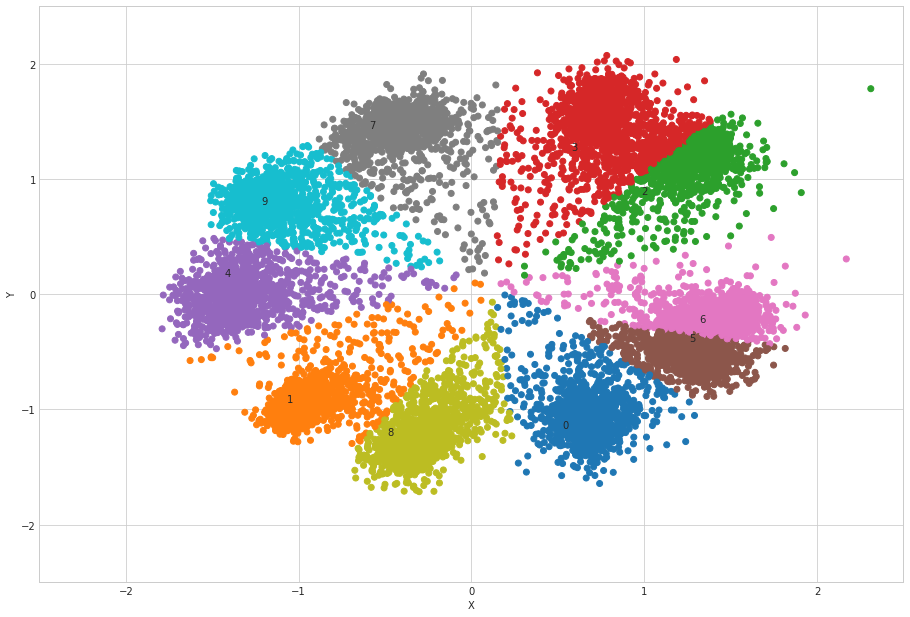

In [50]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)



class Plot_Report(object):
    def __init__(self, centers):
        self.fig = plt.figure()
        self.ax = self.fig.add_axes([-2,-2,2,2])
        self.centers = centers
        self.center_names = ["0","1","2","3","4","5","6","7","8","9"]
        self.cmap = colors.ListedColormap(['#1f77b4', '#ff7f0e', 
                              '#2ca02c', '#d62728', 
                              '#9467bd', '#8c564b', 
                              '#e377c2', '#7f7f7f', 
                              '#bcbd22', '#17becf'])
        #self.cmap = discrete_cmap(10, 'cubehelix')
        
    def plot_data(self,x,y,c):
        self.ax.scatter(x,y, c=c , cmap=self.cmap, vmin=0, vmax=9) #, c=1 cmap=cmap
        
    def plot_centers(self):
        self.ax.scatter(self.centers[:,0],self.centers[:,1], c=[i for i in range(10)] , cmap=self.cmap, vmin=0, vmax=9) #, c=1 cmap=cmap
        for i, txt in enumerate(self.center_names):
            self.ax.annotate(txt, (self.centers[i,0], self.centers[i,1]))
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        
    def show(self):
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.show()
        
myplot = Plot_Report(np.array(model.centers))

myplot.plot_data(features[:,0],features[:,1],y_pred_label)
myplot.plot_centers()
myplot.show()

In [206]:
y_pred_label.min()


1

In [191]:
tf.argmax(y_pred[1])



<tf.Tensor: shape=(), dtype=int64, numpy=8>